# Wicker Hello World

In this tutorial we demonstrate how to write and read a dataset given only a S3 bucket as infrastructure. <br>
You will need to specify your S3 configuration via the `.wickerconfig.json` file (see [Getting Started](https://github.com/woven-planet/wicker/blob/main/docs/source/getstarted.rst) for details)

### Environment Setup
Install wicker with the spark plugin into your a new virtual environment.
For this tutorial you should also have numpy and pillow installed

In [ ]:
# !pip install wicker[spark] numpy pillow

Download and untar the cifar10 dataset

In [ ]:
# curl and untar the Cifar dataset
# !curl https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz --output cifar10.tgz
# !tar -xvf cifar10.tgz

### Writing the Dataset

The Cifar-10 dataset consists of 60k images with 10 possible labels partitioned into 50k train and 10k test sets. <br>
Each image is 32,32,3 so we can define the dataset schema with a string field for the label and a numpy field for the image. 
<br>  We also need to provide primary key(s) using the field values. The primary key tuple should be a unique identifier for the example over the dataset. In most real-world cases we might supply something like a tuple of the timestamp of collection and the id of the collection device, here we can just generate an arbitrary UUID. 

In [ ]:
from wicker import schema

DATASET_SCHEMA = schema.DatasetSchema(
    fields=[
        schema.StringField("label", description="ground truth label of our image"),
        schema.StringField("id", description="uniqe id of data sample"),
        schema.NumpyField("image", shape=(-1, -1, 3), dtype="uint8", description="image as a numpy array"),
    ],
    primary_keys=["label", "id"], # tuple must be unique over the dataset
)


Additionally we supply a name and version for the dataset

In [ ]:
DATASET_NAME = "cifar10"
DATASET_VERSION = "0.0.1"

Next let's organize the data so we can more easily persist it in our dataset. 
This dataset is relatively small (<200 Mb) so we can just read everything into local memory

In [ ]:
import os
import numpy as np
import uuid

from PIL import Image

# replace with default path to cifar10
DEFAULT_DATA_PATH = '/code/cifar10' #os.getcwd()+'/cifar10'

if not os.path.isdir(DEFAULT_DATA_PATH): 
    raise OSError(f"cifar10 directory does not exist at {os.getcwd()}")

path = os.walk(DEFAULT_DATA_PATH)
dataset = []
for root, directories, files in path:
    if files:
        root_split = root.split('/')
        partition = root_split[-2] # train, test folders
        label = root_split[-1] # images for each label type are in a folder with that label name
        print(f'{partition}, {label}')
    for file in files:
        im = np.asarray(Image.open(root+'/'+file))
        dataset.append({'partition_name': partition, 
                        'raw_data':{'label': label, 'id': str(uuid.uuid4()), 'image': im}})

In this example we'll use the spark plugin and a local spark cluster to persist and shuffle our data. <br>
To use the spark API you will just need to supply an RDD containing:

1. The dataset partition
2. A dictionary of the data to be persisted

i.e. pyspark.rdd.RDD[Tuple[str, Dict[str, Any]]]

Let's look at the example below using a local spark cluster:

In [ ]:
from wicker.plugins.spark import persist_wicker_dataset
from pyspark.sql import SparkSession
import copy

In [ ]:
# create a local spark session
spark_session = SparkSession.builder.appName("test").master("local[*]")
spark = spark_session.getOrCreate()
sc = spark.sparkContext

In [ ]:
# create RDD containing partition name and raw data
# note that if you are running a local spark cluster you may 
# increase the number of partitions so your stages don't become too big.
# here we use 256
rdd = sc.parallelize(copy.deepcopy(dataset), numSlices=512)
data_rdd = rdd.map(lambda data_dict: data_dict["raw_data"])
partition_name_rdd = rdd.map(lambda data_dict: data_dict["partition_name"])
partition_rdd = partition_name_rdd.zip(data_rdd)
partition_rdd.cache()

In [ ]:
persist_wicker_dataset(
    DATASET_NAME,
    DATASET_VERSION,
    DATASET_SCHEMA,
    partition_rdd,
)

If successful, the output of the previous cell should be `{'train': 50000, 'test': 10000}` <br>
signifying that 50k examples were written to the train partition and 10k to the test partition

That's it! Our data has been shuffled and is now in our S3 bucket

## Reading the Dataset

Now let's read examples from the train partition of our dataset
Note that we can load subsets of the data, we don't actually care about the id so let's forget about it

In [1]:
from wicker.core.datasets import S3Dataset

DATASET_NAME = "cifar10"
DATASET_VERSION = "0.0.1"

# initialize dataset with subset of data columns
ds = S3Dataset(DATASET_NAME, DATASET_VERSION, "train", columns_to_load=['label', 'image'])

In [2]:
%%time
x0 = ds[0]
# Accessing the first element hits s3 
# and loads data into memory O(100 ms)

CPU times: user 156 ms, sys: 28 ms, total: 184 ms
Wall time: 613 ms


In [3]:
%%time
x1 = ds[1]
# access to contiguous indices is fast O(1 ms)

CPU times: user 1.78 ms, sys: 0 ns, total: 1.78 ms
Wall time: 1.23 ms


In [4]:
%%time
x2 = ds[25000]
# accessing a sample not in downloaded block results 
# in a cache miss and data is loaded from s3

# the number contiguous rows loaded from storage is configurable and 
# can be tuned by the user based on specific training parameters like hardware resources and size of each training example 

CPU times: user 1.77 ms, sys: 324 µs, total: 2.1 ms
Wall time: 1.63 ms


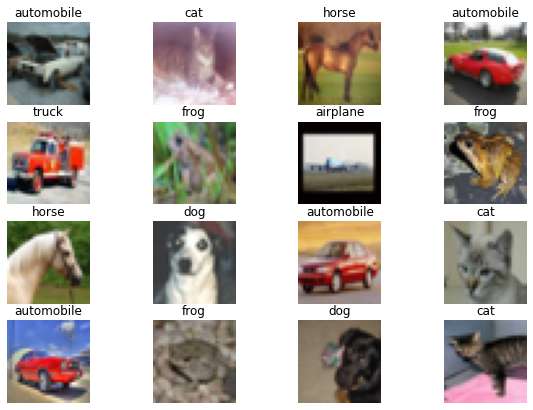

In [5]:
# pip install matplotlib if not already in your environment
import random
from matplotlib import pyplot as plt
from PIL import Image
fig = plt.figure(figsize=(10, 7))

for i in range(16):
    idx=random.randint(0, 50000) 
    img = Image.fromarray(ds[idx]['image'])
    label = ds[idx]['label']
    fig.add_subplot(4, 4, i+1)
    plt.axis('off')
    plt.title(label)
    plt.imshow(img)